### Import packages

In [1]:
import sys
import pandas as pd
print(pd.__version__)
import os
import torch as th
print(th.backends.mps.is_available())
import numpy as np
import gymnasium as gym
print(gym.__version__)
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed

from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from datetime import datetime, timedelta

# vectorized environment
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback

print(MAX_AIRCRAFT)
import warnings

from stable_baselines3.common.utils import polyak_update
from stable_baselines3.common.logger import configure  # Import the configure function


import stable_baselines3
print(stable_baselines3.__version__)


import stable_baselines3

import gym
print("Stable Baselines3 version:", stable_baselines3.__version__)
print("Gym version:", gym.__version__)

import math



2.2.2
True
0.29.1
3
2.3.2
Stable Baselines3 version: 2.3.2
Gym version: 0.26.2


In [2]:
import subprocess
import re
import subprocess
import platform
import re

def get_macbook_info():
    model_info = subprocess.run(["system_profiler", "SPHardwareDataType"], capture_output=True, text=True)
    output = model_info.stdout
    
    # Extract relevant information
    model_name = re.search(r"Model Name: (.*)", output)
    chip = re.search(r"Chip: (.*)", output)
    total_cores = re.search(r"Total Number of Cores: (.*)", output)
    memory = re.search(r"Memory: (.*)", output)
    
    info = {
        "Model Name": model_name.group(1) if model_name else "Unknown",
        "Chip": chip.group(1) if chip else "Unknown",
        "Total Cores": total_cores.group(1) if total_cores else "Unknown",
        "Memory": memory.group(1) if memory else "Unknown"
    }
    
    return info



def get_gpu_info():
    if platform.system() == "Darwin":  # macOS
        gpu_info = subprocess.run(["system_profiler", "SPDisplaysDataType"], capture_output=True, text=True)
        output = gpu_info.stdout
        chipset_model = re.search(r"Chipset Model: (.*)", output)
        type = re.search(r"Type: (.*)", output)
        return {
            "Chipset Model": chipset_model.group(1) if chipset_model else "Unknown",
            "Type": type.group(1) if type else "Unknown"
        }
    elif platform.system() == "Windows" or platform.system() == "Linux":
        gpu_info = subprocess.run(["nvidia-smi", "--query-gpu=name,memory.total", "--format=csv,noheader"], capture_output=True, text=True)
        output = gpu_info.stdout.strip()
        if output:
            name, memory = output.split(', ')
            return {
                "GPU Name": name,
                "Memory Total": memory
            }
        else:
            return "No NVIDIA GPU found or `nvidia-smi` not available."
    else:
        return "Unsupported OS"


import subprocess

def get_l40s_info():
    # Querying memory usage, GPU utilization, temperature, etc.
    gpu_info = subprocess.run(
        ["nvidia-smi", "--query-gpu=name,driver_version,memory.total,memory.used,memory.free,utilization.gpu,temperature.gpu",
         "--format=csv,noheader"],
        capture_output=True, text=True
    )
    output = gpu_info.stdout.strip()
    if output:
        fields = output.split(', ')
        return {
            "GPU Name": fields[0],
            "Driver Version": fields[1],
            "Total Memory": fields[2],
            "Used Memory": fields[3],
            "Free Memory": fields[4],
            "GPU Utilization": fields[5],
            "Temperature": fields[6]
        }
    else:
        return "No detailed information available or `nvidia-smi` not available."



# device_info = get_l40s_info()
# print("Detailed GPU Info:", device_info)


In [3]:
# Set debugs to False
DEBUG_MODE = False  # Turn on/off debug mode
DEBUG_MODE_TRAINING = False  # Turn on/off debug mode for training
DEBUG_MODE_REWARD = False  # Turn on/off debug mode for reward calculation
DEBUG_MODE_PRINT_STATE = False  # Turn on/off debug mode for printing state
DEBUG_MODE_CANCELLED_FLIGHT = False  # Turn on/off debug mode for cancelled flight

### Hyperparameters

In [4]:
# Training Settings
LEARNING_RATE = 0.001
GAMMA = 0.99
BUFFER_SIZE = 50000
BATCH_SIZE = 64*4
TARGET_UPDATE_INTERVAL = 100
EPSILON_START = 1.0
EPSILON_MIN = 0.05
EPSILON_DECAY_RATE = 0.00006
MAX_TIMESTEPS = 500         # maximum number of timesteps per episode (not relevant here)

LEARNING_STARTS = 0 # means that the model will start learning after 1000 timesteps
TRAIN_FREQ = 4

N_EPISODES = 5          # number of episodes PER TRAINING SCENARIO
NEURAL_NET_STRUCTURE = dict(net_arch=[256, 256*2,256]) # hidden layer sizes



TRAINING_FOLDERS_PATH = '../data/Training/1k-3ac-12f-1dis-F/'

# print info on the device used like macbook pro m1

if th.cuda.is_available():
    device = th.device('cuda')
elif th.backends.mps.is_available():
    device = th.device('mps')
else:
    device = th.device('cpu')

print(f"Using device: {device}")


# code to see what hardware is available
import torch

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Number of GPUs available
print("Number of GPUs available:", torch.cuda.device_count())

# Get the name of the current GPU
if torch.cuda.is_available():
    print("Current GPU name:", torch.cuda.get_device_name())

# Check if cuDNN is enabled
print("cuDNN enabled:", torch.backends.cudnn.enabled)

# Convert device to a string representation for comparison
device_str = str(device).lower()  # Convert to string and lowercase

print("Device:", device_str)

if device_str == 'mps':
    print("Using MacBook M1")
    macbook_info = get_macbook_info()
    gpu_info = get_gpu_info()
    device_info = {**macbook_info, **gpu_info}
elif device_str == 'cuda':
    print("Using GPU")
    # Get gpu name and short info
    device_info = get_gpu_info()
    
else:
    print("Using CPU")
    device_info = get_macbook_info()

print(f"Device info: {device_info}")



# Verify folders exists
if not os.path.exists(TRAINING_FOLDERS_PATH):
    raise FileNotFoundError(f'Training folder not found at {TRAINING_FOLDERS_PATH}')

# print all folders in the training folder
training_folders = []
for folder in os.listdir(TRAINING_FOLDERS_PATH):
    if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder)):
        training_folders.append(folder)


        
last_folder = os.path.basename(os.path.normpath(TRAINING_FOLDERS_PATH))

num_days_trained_on = N_EPISODES * len(training_folders)
print(f'Training on {num_days_trained_on} days of data ({N_EPISODES} episodes of {len(training_folders)} scenarios)')

# Function to format the number of days
def format_days(days):
    if days >= 1000000:
        return f"{math.floor(days/1000000)}M"
    elif days >= 1000:
        return f"{math.floor(days/1000)}k"
    else:
        return str(days)

how_much = format_days(num_days_trained_on)

model_name = last_folder
print('Model name:', model_name)
model_version = get_model_version(model_name)
MODEL_SAVE_PATH = f'../trained_models/{model_name}-{how_much}-{model_version}.zip'

print('Model will be saved to:', MODEL_SAVE_PATH)


# Create a new results directory with thwe current datetime
now = datetime.now()
folder_name = now.strftime('%Y%m%d-%H-%M')
results_dir = os.path.join('..', 'results', folder_name)
os.makedirs(results_dir, exist_ok=True)

# create a new folder within results_dir called plots
os.makedirs(os.path.join(results_dir, 'plots'), exist_ok=True)


Using device: mps
CUDA available: False
Number of GPUs available: 0
cuDNN enabled: True
Device: mps
Using MacBook M1
Device info: {'Model Name': 'MacBook Pro', 'Chip': 'Apple M3 Max', 'Total Cores': '14 (10 performance and 4 efficiency)', 'Memory': '36 GB', 'Chipset Model': 'Apple M3 Max', 'Type': 'GPU'}
Training on 5000 days of data (5 episodes of 1000 scenarios)
Model name: 1k-3ac-12f-1dis-F
Model will be saved to: ../trained_models/1k-3ac-12f-1dis-F-5k-6.zip


## Estimated epsilon decay

Estimated total timesteps for training: 12810
Epsilon reaches its minimum value at 0.00% of total timesteps.


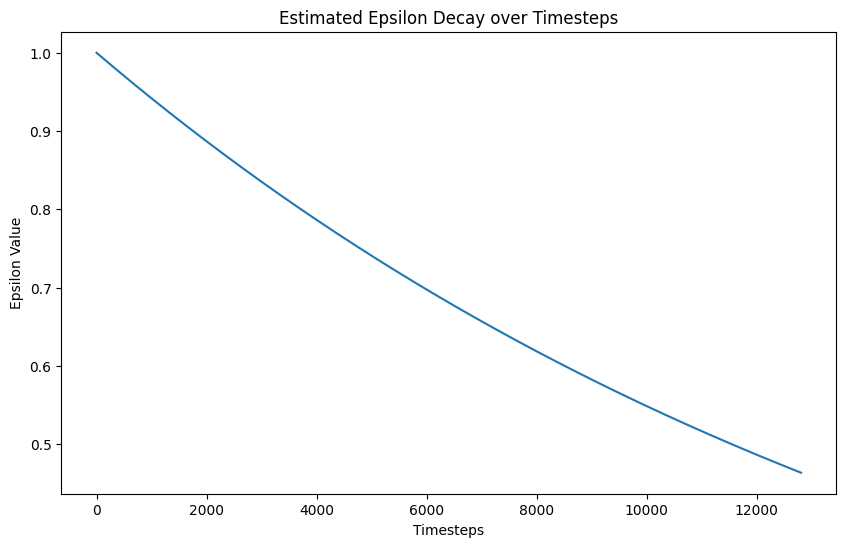

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from src.environment_myopic import AircraftDisruptionEnv

# Initialize variables
total_timesteps_per_batch = 0
timesteps_per_scenario = []

# List all the scenario folders in Data/Training
scenario_folders = [
    os.path.join(TRAINING_FOLDERS_PATH, folder)
    for folder in os.listdir(TRAINING_FOLDERS_PATH)
    if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder))
]

# Simulate one batch with a random agent
for scenario_folder in scenario_folders:
    # print(f"Training on scenario {scenario_folder}")
    # Load the data for the current scenario
    data_dict = load_scenario_data(scenario_folder)
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize the environment
    env = AircraftDisruptionEnv(
        aircraft_dict,
        flights_dict,
        rotations_dict,
        alt_aircraft_dict,
        config_dict
    )

    # Reset the environment
    obs, _ = env.reset()

    done_flag = False
    timesteps = 0

    while not done_flag and timesteps < MAX_TIMESTEPS:
        # Take a random action
        action = env.action_space.sample()

        # Take action in the environment
        obs_next, reward, terminated, truncated, info = env.step(action)

        # Update the current observation
        obs = obs_next

        # Combine the terminated and truncated flags into a single done flag
        done_flag = terminated or truncated

        timesteps += 1

        # Check if the episode is done
        if done_flag:
            break

    # Accumulate timesteps
    total_timesteps_per_batch += timesteps
    timesteps_per_scenario.append(timesteps)

# Estimate total timesteps for the entire training process
total_timesteps_estimate = total_timesteps_per_batch * N_EPISODES

print(f"Estimated total timesteps for training: {total_timesteps_estimate}")

# Generate epsilon values over the estimated total timesteps
epsilon_values_estimate = []
epsilon = EPSILON_START
min_epsilon_reached_at = 0

for t in range(int(total_timesteps_estimate)):
    epsilon = max(EPSILON_MIN, epsilon * (1 - EPSILON_DECAY_RATE))
    epsilon_values_estimate.append(epsilon)
    
    # Record when epsilon reaches the minimum value
    if epsilon == EPSILON_MIN:
        min_epsilon_reached_at = t
        # Extend the list with EPSILON_MIN for the remaining timesteps
        epsilon_values_estimate.extend([EPSILON_MIN] * (int(total_timesteps_estimate) - t - 1))
        break

# Calculate the percentage of timesteps where epsilon reaches its minimum value
percentage_min_epsilon_reached = (min_epsilon_reached_at / total_timesteps_estimate) * 100
print(f"Epsilon reaches its minimum value at {percentage_min_epsilon_reached:.2f}% of total timesteps.")


# Plot the estimated epsilon decay curve
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values_estimate)
plt.xlabel('Timesteps')
plt.ylabel('Epsilon Value')
plt.title('Estimated Epsilon Decay over Timesteps')
plt.show()

# Interrupt the code if epsilon reaches its minimum value below 70% of the total timesteps
# if percentage_min_epsilon_reached < 70:
#     raise RuntimeError("Epsilon reaches its minimum value below 70% of total timesteps. Aborting the process.")



# Reinforcement Learning

## Environment

In [6]:
from src.environment_myopic import AircraftDisruptionEnv



## Training

In [7]:
start_time = datetime.now()


# Initialize variables
rewards = []
epsilon_values = []
total_timesteps = 0
action_sequences = {
    os.path.join(TRAINING_FOLDERS_PATH, folder): {
        "best_actions": [],
        "best_reward": float('-inf'),
        "worst_actions": [],
        "worst_reward": float('inf')
    }
    for folder in training_folders
}

def train_dqn_agent():
    # List all the scenario folders in Data/Training
    scenario_folders = [
        os.path.join(TRAINING_FOLDERS_PATH, folder)
        for folder in os.listdir(TRAINING_FOLDERS_PATH)
        if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder))
    ]

    epsilon = EPSILON_START
    global total_timesteps

    # Initialize the DQN
    dummy_scenario_folder = scenario_folders[0]
    data_dict = load_scenario_data(dummy_scenario_folder)
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']
    env = AircraftDisruptionEnv(
        aircraft_dict,
        flights_dict,
        rotations_dict,
        alt_aircraft_dict,
        config_dict
    )

    model = DQN(
        policy='MlpPolicy',
        env=env,
        learning_rate=LEARNING_RATE,
        gamma=GAMMA,
        buffer_size=BUFFER_SIZE,
        learning_starts=LEARNING_STARTS,
        batch_size=BATCH_SIZE,
        target_update_interval=TARGET_UPDATE_INTERVAL,
        verbose=0,
        policy_kwargs=NEURAL_NET_STRUCTURE,
        device=device
    )

    
    logger = configure() 
    model._logger = logger 

    # Training loop over the number of episodes
    for episode in range(N_EPISODES):
        # Cycle through all the scenario folders
        for scenario_folder in scenario_folders:
            if DEBUG_MODE_TRAINING:
                print(f"Training on scenario {scenario_folder}")

            # Load the data for the current scenario
            data_dict = load_scenario_data(scenario_folder)
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            # Update the environment with the new scenario (by reinitializing it)
            env = AircraftDisruptionEnv(
                aircraft_dict,
                flights_dict,
                rotations_dict,
                alt_aircraft_dict,
                config_dict
            )
            model.set_env(env)  # Update the model's environment with the new instance

            # Reset the environment
            obs, _ = env.reset()  # Extract the observation (obs) and ignore the info (_)

            done_flag = False
            total_reward = 0
            timesteps = 0
            action_sequence = []

            while not done_flag and timesteps < MAX_TIMESTEPS:
                model.exploration_rate = epsilon

                # Call model.predict using only the observation
                action, _ = model.predict(obs, deterministic=False)

                # Take action in the environment
                result = env.step(action)

                # Unpack the result (5 values)
                obs_next, reward, terminated, truncated, info = result

                # Combine the terminated and truncated flags into a single done flag
                done_flag = terminated or truncated

                # Store the action
                action_sequence.append(action)

                # Accumulate the reward
                total_reward += reward

                # Add the transition to the replay buffer
                model.replay_buffer.add(
                    obs=obs,
                    next_obs=obs_next,
                    action=action,
                    reward=reward,
                    done=done_flag,
                    infos=[info]
                )

                # Update the current observation
                obs = obs_next

                # Update epsilon (exploration rate)
                epsilon = max(EPSILON_MIN, epsilon * (1 - EPSILON_DECAY_RATE))
                epsilon_values.append(epsilon)

                timesteps += 1
                total_timesteps += 1

                # Training
                if total_timesteps > model.learning_starts and total_timesteps % TRAIN_FREQ == 0:
                    # Perform a training step
                    model.train(gradient_steps=1, batch_size=BATCH_SIZE)

                # Update target network
                if total_timesteps % model.target_update_interval == 0:
                    polyak_update(model.q_net.parameters(), model.q_net_target.parameters(), model.tau)
                    # Copy batch norm stats
                    polyak_update(model.batch_norm_stats, model.batch_norm_stats_target, 1.0)

                # Check if the episode is done
                if done_flag:
                    break

            # Store the total reward for the episode with the scenario specified
            rewards.append((episode, scenario_folder, total_reward))

            # Update the worst and best action sequences
            if total_reward < action_sequences[scenario_folder]["worst_reward"]:
                action_sequences[scenario_folder]["worst_actions"] = action_sequence
                action_sequences[scenario_folder]["worst_reward"] = total_reward

            if total_reward > action_sequences[scenario_folder]["best_reward"]:
                action_sequences[scenario_folder]["best_actions"] = action_sequence
                action_sequences[scenario_folder]["best_reward"] = total_reward

        print(f"({episode + 1}/{N_EPISODES})")

    # Save the model after training
    model.save(MODEL_SAVE_PATH)


train_dqn_agent()

# Output total timesteps
print(total_timesteps)

# Output scenario action sequences and rewards
for scenario, data in action_sequences.items():
    print(f"Scenario: {scenario}, Worst Reward: {data['worst_reward']}, Best Reward: {data['best_reward']}")
    print(f"Worst Action Sequence: {data['worst_actions']}")
    print(f"Best Action Sequence: {data['best_actions']}")

    # Save the action sequences to a CSV file
    save_best_and_worst_to_csv(
        scenario,
        MODEL_SAVE_PATH,
        data['worst_actions'],
        data['best_actions'],
        data['worst_reward'],
        data['best_reward']
    )


end_time = datetime.now()
runtime = end_time - start_time
runtime_in_seconds = runtime.total_seconds()

# create new folder within results_dir called action_sequences
os.makedirs(os.path.join(results_dir, 'action_sequences'), exist_ok=True)



# Collect hyperparameters and other details
hyperparameters = {
    'LEARNING_RATE': LEARNING_RATE,
    'GAMMA': GAMMA,
    'BUFFER_SIZE': BUFFER_SIZE,
    'BATCH_SIZE': BATCH_SIZE,
    'TARGET_UPDATE_INTERVAL': TARGET_UPDATE_INTERVAL,
    'EPSILON_START': EPSILON_START,
    'EPSILON_MIN': EPSILON_MIN,
    'EPSILON_DECAY_RATE': EPSILON_DECAY_RATE,
    'MAX_TIMESTEPS': MAX_TIMESTEPS,
    'LEARNING_STARTS': LEARNING_STARTS,
    'TRAIN_FREQ': TRAIN_FREQ,
    'N_EPISODES': N_EPISODES,
    'NEURAL_NET_STRUCTURE': NEURAL_NET_STRUCTURE,
    'TRAINING_FOLDERS_PATH': TRAINING_FOLDERS_PATH,
    'model_name': model_name,
    'model_version': model_version,
    'MODEL_SAVE_PATH': MODEL_SAVE_PATH,
    'runtime_in_seconds': runtime_in_seconds,
    'runtime_in_hh:mm:ss': str(runtime) if runtime_in_seconds > 0 else "0:00:00",
    'total_timesteps': total_timesteps,


    #  values from config.py
    'MAX_AIRCRAFT': MAX_AIRCRAFT,
    'MAX_FLIGHTS_PER_AIRCRAFT': MAX_FLIGHTS_PER_AIRCRAFT,
    'TIMESTEP_HOURS': TIMESTEP_HOURS,
    'DUMMY_VALUE': DUMMY_VALUE,
    'RESOLVED_CONFLICT_REWARD': RESOLVED_CONFLICT_REWARD,
    'DELAY_MINUTE_PENALTY': DELAY_MINUTE_PENALTY,
    'MAX_DELAY_PENALTY': MAX_DELAY_PENALTY,
    'NO_ACTION_PENALTY': NO_ACTION_PENALTY,
    'CANCELLED_FLIGHT_PENALTY': CANCELLED_FLIGHT_PENALTY,
    'MIN_TURN_TIME': MIN_TURN_TIME,

    # device info
    'device': device,
    'device_info': device_info
    
}

# Save hyperparameters to CSV
hyperparameters_df = pd.DataFrame(list(hyperparameters.items()), columns=['Parameter', 'Value'])
hyperparameters_df.to_csv(os.path.join(results_dir, 'hyperparameters.csv'), index=False)

# Save the action sequences to CSV files in the results directory
for scenario, data in action_sequences.items():
    scenario_name = os.path.basename(scenario)
    worst_actions_df = pd.DataFrame(data['worst_actions'], columns=['Action'])
    best_actions_df = pd.DataFrame(data['best_actions'], columns=['Action'])
    worst_actions_df.to_csv(os.path.join(results_dir, 'action_sequences', f'{scenario_name}_worst_actions.csv'), index=False)
    best_actions_df.to_csv(os.path.join(results_dir, 'action_sequences', f'{scenario_name}_best_actions.csv'), index=False)

Logging to /var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/SB3-2024-11-15-12-08-30-858377
(1/5)
(2/5)
(3/5)
(4/5)
(5/5)
16298
Scenario: ../data/Training/1k-3ac-12f-1dis-F/Scenario_264, Worst Reward: -6282.0, Best Reward: -1612.0
Worst Action Sequence: [array(2), array(3), array(1)]
Best Action Sequence: [array(1), array(0), array(3), array(0), array(1)]
Scenario: ../data/Training/1k-3ac-12f-1dis-F/Scenario_50, Worst Reward: -5917.0, Best Reward: -1434.0
Worst Action Sequence: [array(1), array(2), array(2), array(0), array(3)]
Best Action Sequence: [array(3), array(0), array(0), array(2), array(1), array(2)]
Scenario: ../data/Training/1k-3ac-12f-1dis-F/Scenario_432, Worst Reward: -8238.0, Best Reward: -1703.0
Worst Action Sequence: [array(1), array(1), array(1)]
Best Action Sequence: [array(2), array(3), array(0), array(3)]
Scenario: ../data/Training/1k-3ac-12f-1dis-F/Scenario_600, Worst Reward: 0, Best Reward: 0
Worst Action Sequence: [array(0)]
Best Action Sequence: [array(0)]
Scenar

num_days_trained_on 5000
Trained on 5000 days of data (1000 unique scenarios)


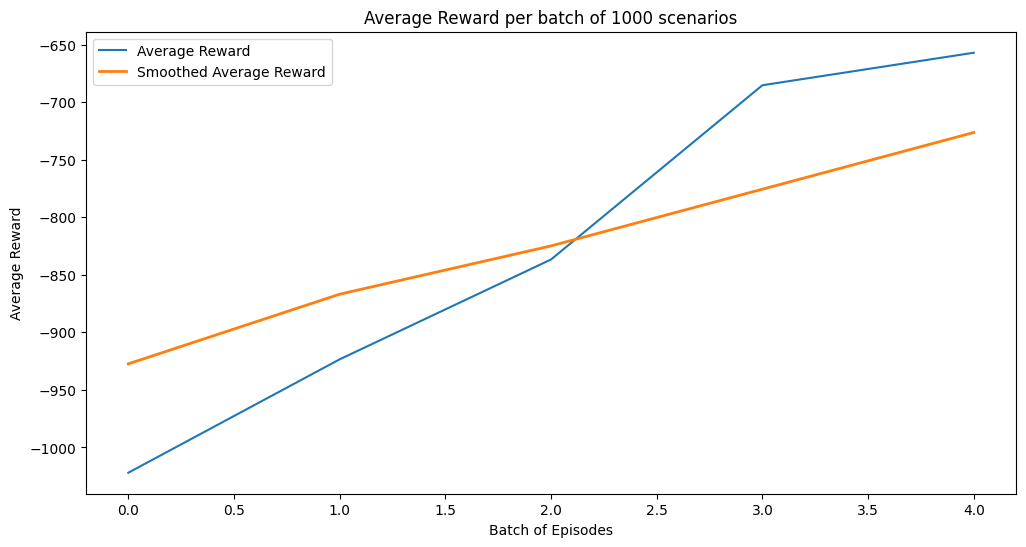

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated input
print(f"num_days_trained_on {num_days_trained_on}")
rewards_per_day = len(rewards) // num_days_trained_on  

# Print out the structure of the rewards list
print(f"Trained on {num_days_trained_on} days of data ({len(training_folders)} unique scenarios)")

avg_rewards_per_batch = []
total_reward_per_batch = []

# amount of scenarios:
num_scenarios = len(training_folders)

# Average reward for every iteration of the scenarios
for i in range(0, len(rewards), len(training_folders)):
    avg_rewards_per_batch.append(np.mean([reward for _, _, reward in rewards[i:i+num_scenarios]]))
    total_reward_per_batch.append(np.sum([reward for _, _, reward in rewards[i:i+num_scenarios]]))

# centered moving window
window = 5

avg_rewards_series = pd.Series(avg_rewards_per_batch)
smoothed_avg_rewards_per_batch = avg_rewards_series.rolling(window=window, center=True, min_periods=1).mean()

total_rewards_series = pd.Series(total_reward_per_batch)
smoothed_total_rewards_per_batch = total_rewards_series.rolling(window=window, center=True, min_periods=1).mean()

# Plot the average rewards over the episodes
plt.figure(figsize=(12, 6))
plt.plot(avg_rewards_series.index, avg_rewards_series.values, label='Average Reward')
plt.plot(smoothed_avg_rewards_per_batch.index, smoothed_avg_rewards_per_batch.values, label='Smoothed Average Reward', linewidth=2)
plt.legend()
plt.xlabel('Batch of Episodes')
plt.ylabel('Average Reward')
plt.title(f'Average Reward per batch of {num_scenarios} scenarios')
plt.savefig(os.path.join(results_dir, 'plots', 'average_reward_per_batch.png'))
plt.show()

# Plot the total rewards over the episodes
plt.figure(figsize=(12, 6))
plt.plot(total_rewards_series.index, total_rewards_series.values, label='Total Reward')
plt.plot(smoothed_total_rewards_per_batch.index, smoothed_total_rewards_per_batch.values, label='Smoothed Total Reward', linewidth=2)
plt.legend()
plt.xlabel('Batch of Episodes')
plt.ylabel('Total Reward')
plt.title(f'Total Reward per batch of {num_scenarios} scenarios')
plt.savefig(os.path.join(results_dir, 'plots', 'total_reward_per_batch.png'))
plt.close()


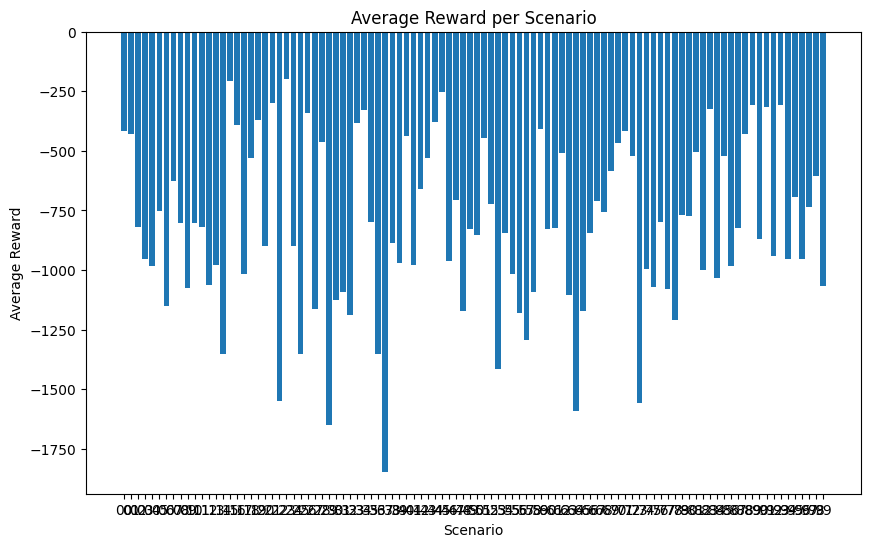

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize a dictionary to store rewards for each scenario
scenario_rewards = defaultdict(list)

# Iterate through the rewards list and group by scenario (last two characters)
for _, scenario, reward in rewards:
    scenario_id = scenario[-2:]  # Get the last two characters (e.g., '01', '02', etc.)
    scenario_rewards[scenario_id].append(reward)

# calculate the average reward for each scenario
avg_rewards_per_batch_per_scenario = {scenario: np.mean(rewards) for scenario, rewards in scenario_rewards.items()}
sorted_scenarios = sorted(avg_rewards_per_batch_per_scenario.keys())

# Extract the sorted average rewards
sorted_avg_rewards_per_batch = [avg_rewards_per_batch_per_scenario[scenario] for scenario in sorted_scenarios]

# Plot a bar chart with scenarios on the x-axis and average rewards on the y-axis
plt.figure(figsize=(10, 6))
plt.bar(sorted_scenarios, sorted_avg_rewards_per_batch)
plt.xlabel('Scenario')
plt.ylabel('Average Reward')
plt.title('Average Reward per Scenario')
plt.savefig(os.path.join(results_dir, 'plots', 'average_reward_per_scenario.png'))
plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Create the new folder within results_dir
scenario_results_dir = os.path.join(results_dir, 'plots', 'reward-plots-per-scenario')
os.makedirs(scenario_results_dir, exist_ok=True)

# Iterate over all scenarios in scenario_rewards
for scenario_id, rewards_list in scenario_rewards.items():
    # Set the smoothing window (adjust the size as needed)
    window = 1000
    # Ensure the window size does not exceed the length of the rewards list
    if len(rewards_list) < window:
        window = len(rewards_list)
    smoothed_rewards = np.convolve(rewards_list, np.ones(window) / window, mode='same')

    plt.figure()
    plt.plot(rewards_list, label='Reward')
    plt.plot(smoothed_rewards, label='Smoothed Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward per Episode for Scenario ' + scenario_id)
    plot_filename = f'average_reward_for_scenario_{scenario_id}.png'
    plt.savefig(os.path.join(scenario_results_dir, plot_filename))
    plt.close()

total_timesteps 16298


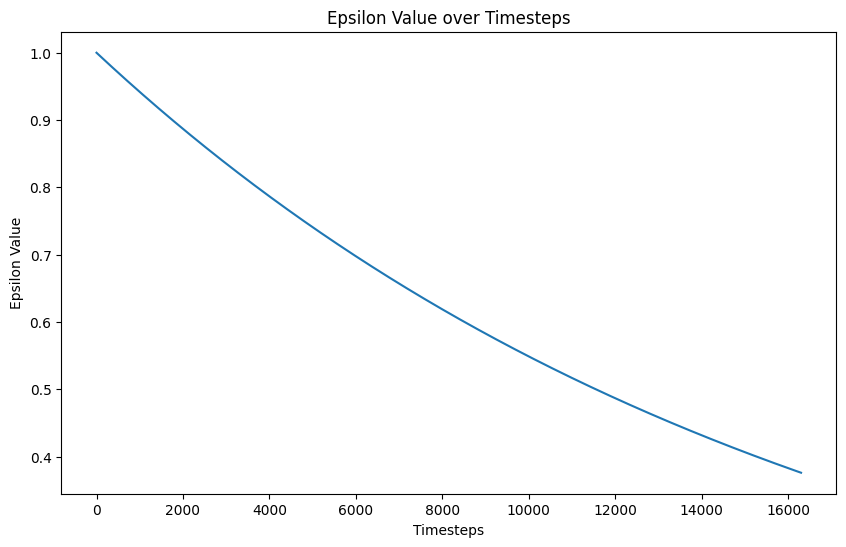

In [11]:
print("total_timesteps", total_timesteps)
# Plot the epsilon values over the episodes 10, 6
plt.figure(figsize=(10, 6))
plt.plot(range(len(epsilon_values)), epsilon_values)
plt.xlabel('Timesteps')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Value over Timesteps')
plt.savefig(os.path.join(results_dir, 'plots', 'epsilon_value_over_timesteps.png'))
plt.show()